# Audio Decoder in DALI

This tutorial presents, how to set up a simple pipeline, that loads and decodes audio data using DALI. We will use a simple example from Speech Commands Data Set. While this dataset consists of samples in .wav format, the following procedure can be used for most of the well-known digital audio coding formats as well.

## Step-by-step guide
1. Let's start by importing DALI and a handful of utils.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
audio_files = "../data/audio"

used `batch_size` is `1`, to keep things simple.

2. Next, let's implement the pipeline. Firstly, we need to load data from disk (or any other source). FileReader is able to load data, as well as it's labels. For more information, refer to FileReader docs. Furthermore, similarly to image data, you can use Reader operators that are specific for a given dataset or a dataset format (see [CaffeReader](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.CaffeReader)). After loading the input data, the pipeline decodes the audio data. As stated above, the AudioDecoder operator is able to decode most of the well-known audio formats.
   
   Note: Please remember that you shall pass proper data type (argument `dtype`) to the operator. Supported data types can be found in the documentation. If you have 24-bit audio data and you set `dtype=INT16`, it will result in loosing some information from the samples. The default `dtype` for this operator is `INT16`

In [2]:
class AudioDecoderExample(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(AudioDecoderExample, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(device="cpu", file_root=audio_files)
        self.decode = ops.AudioDecoder(device="cpu", dtype=types.INT16)

    def define_graph(self):                                                                
        read, _ = self.input()
        audio, rate = self.decode(read)
        return audio, rate

3. Now let's just build and run the pipeline.

In [3]:
pipecpu = AudioDecoderExample(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

Outputs from `AudioDecoder` consist of a tensor with the decoded data, as well as some metadata (e.g. sampling rate). To access them just check another output. On top of that, AudioDecoder returns data in interleaved format, so we need to reshape the output tensor, to properly display it. Here's how to do that:

Sampling rate: 16000 [Hz]
Audio data: [[  -5]
 [ -95]
 [-156]
 ...
 [ 116]
 [ 102]
 [  82]]
Audio data flattened: [  -5  -95 -156 ...  116  102   82]


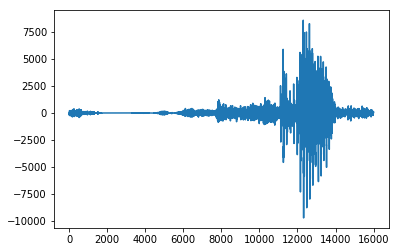

In [4]:
audio_data = cpu_output[0].at(0)
sampling_rate = cpu_output[1].at(0)[0]
print("Sampling rate:", sampling_rate, "[Hz]")
print("Audio data:", audio_data)
audio_data = audio_data.flatten()
print("Audio data flattened:", audio_data)
plt.plot(audio_data)
plt.show()

## Verification

Let's verify, that the AudioDecoder actually works. The presented method can also come in handy for debugging DALI pipeline, in case something doesn't go as planned. 

We will use external tool to decode used data and compare the results against data decoded by DALI.

### Important!

Following snippet installs the external dependency (`simpleaudio`). In case you already have it, or don't want to install it, you might want to stop here and not run this one.

In [ ]:
import sys
!{sys.executable} -m pip install simpleaudio

Below is the side-by-side comparision of decoded data. If you have the `simpleaudio` module installed, you can run the snippet and see it for yourself.

src: simpleaudio
shape:  (16000,)
data:  [  -5  -95 -156 ...  116  102   82]


src: DALI
shape:  (16000,)
data:  [  -5  -95 -156 ...  116  102   82]

Are the arrays equal? YES


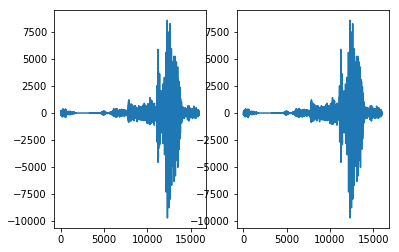

In [5]:
import simpleaudio as sa

wav = sa.WaveObject.from_wave_file("../data/audio/wav/three.wav")
three_audio = np.frombuffer(wav.audio_data, dtype=np.int16)

print("src: simpleaudio")
print("shape: ", three_audio.shape)
print("data: ", three_audio)
print("\n")
print("src: DALI")
print("shape: ", audio_data.shape)
print("data: ", audio_data)
print("\nAre the arrays equal?", "YES" if np.all(audio_data == three_audio) else "NO")

fig, ax = plt.subplots(1,2)
ax[0].plot(three_audio)
ax[1].plot(audio_data)
plt.show()